In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
from function import *

In [3]:
df = make_data(dt=0.01, total_time = 50)

In [11]:
df

,u,time,f
0,0.000000e+00,0.00,0.000000
1,6.279052e-02,0.01,0.152729
2,1.253332e-01,0.02,0.272857
3,1.873813e-01,0.03,0.369560
4,2.486899e-01,0.04,0.449713
...,...,...,...
4996,-2.486899e-01,49.96,0.299277
4997,-1.873813e-01,49.97,0.338483
4998,-1.253332e-01,49.98,0.375216
4999,-6.279052e-02,49.99,0.410140


In [12]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [13]:
train_x = train.iloc[:, :2].values
train_y = train.iloc[:, 2].values
test_x = test.iloc[:, :2].values
test_y = test.iloc[:, 2].values

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()

In [16]:
sc_train_x = scaler.fit_transform(train_x)
sc_test_x = scaler.transform(test_x)

sc_train_y = scaler.fit_transform(train_y.reshape(-1, 1))
sc_test_y = scaler.transform(test_y.reshape(-1, 1))

In [17]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not available")


GPU not available


In [13]:
model = hysterisis_curve(sc_train_x, sc_train_y, sc_test_x, sc_test_y)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [14]:
model.dnn_fit(epochs=100, batch_size=1)

Epoch 1/100
4000/4000 [==============================] - 3s 553us/step - loss: 0.1854 - mse: 0.1854
Epoch 2/100
4000/4000 [==============================] - 2s 535us/step - loss: 0.1675 - mse: 0.1675
Epoch 3/100
4000/4000 [==============================] - 2s 544us/step - loss: 0.1643 - mse: 0.1643
Epoch 4/100
4000/4000 [==============================] - 2s 559us/step - loss: 0.1629 - mse: 0.1629
Epoch 5/100
4000/4000 [==============================] - 2s 566us/step - loss: 0.1628 - mse: 0.1628
Epoch 6/100
4000/4000 [==============================] - 2s 546us/step - loss: 0.1611 - mse: 0.1611
Epoch 7/100
4000/4000 [==============================] - 2s 545us/step - loss: 0.1613 - mse: 0.1613
Epoch 8/100
4000/4000 [==============================] - 2s 542us/step - loss: 0.1616 - mse: 0.1616
Epoch 9/100
4000/4000 [==============================] - 2s 544us/step - loss: 0.1606 - mse: 0.1606
Epoch 10/100
4000/4000 [==============================] - 2s 548us/step - loss: 0.1608 - mse: 0.1608

In [15]:
pred = model.dnn_predict()

32/32 [==============================] - 0s 516us/step


In [16]:
real_pred = scaler.inverse_transform(pred)

In [17]:
test_x[:,0]

array([-9.79717439e-15,  6.27905195e-02,  1.25333234e-01, ...,
       -1.25333234e-01, -6.27905195e-02,  1.96438672e-15])

In [18]:
real_pred.reshape(1,-1)[0]

array([-0.0044891 ,  0.02621681,  0.04961443, ..., -0.03394944,
       -0.01949993, -0.00759609], dtype=float32)

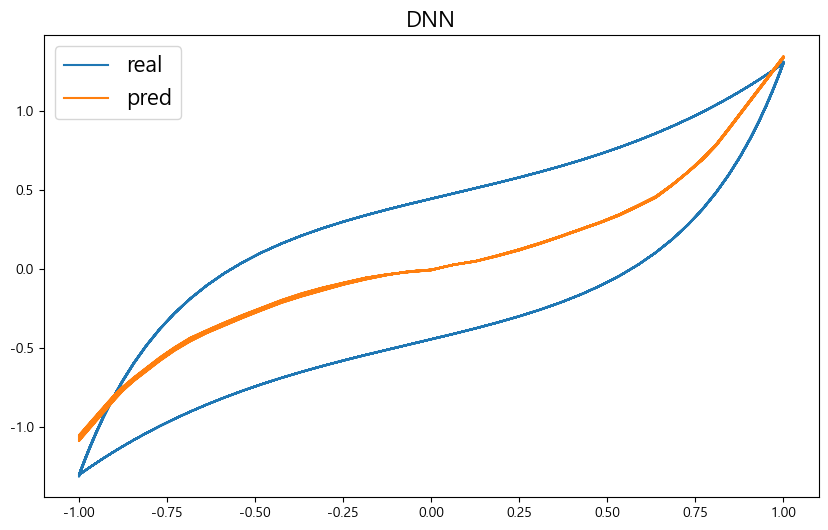

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(test_x[:,0], test_y, label='real')
plt.plot(test_x[:,0], real_pred.reshape(1,-1)[0], label='pred')
plt.title('DNN', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

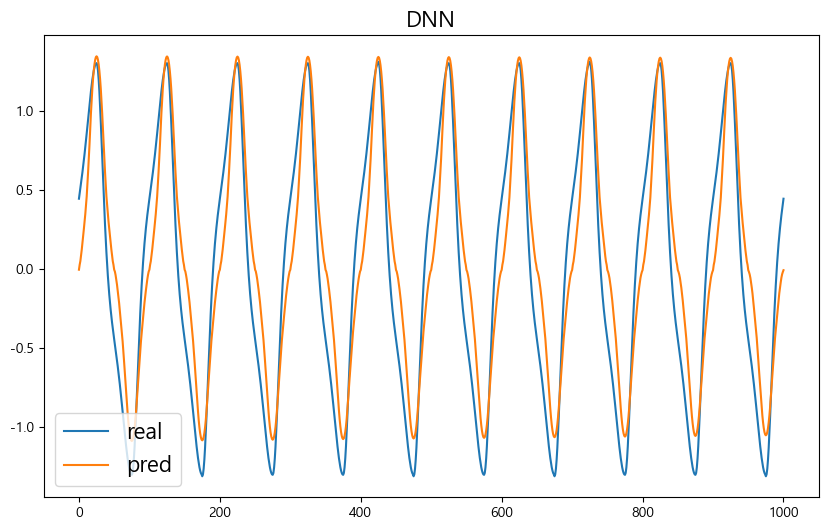

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(test_y, label = 'real')
plt.plot(real_pred.reshape(1,-1)[0], label = 'pred')
plt.title('DNN', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [21]:
lstm_history = model.lstm_fit(epochs=100, batch_size=1)

Epoch 1/100
4000/4000 [==============================] - 7s 1ms/step - loss: 0.1996 - mse: 0.1996
Epoch 2/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1710 - mse: 0.1710
Epoch 3/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1672 - mse: 0.1672
Epoch 4/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1658 - mse: 0.1658
Epoch 5/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1656 - mse: 0.1656
Epoch 6/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1638 - mse: 0.1638
Epoch 7/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1648 - mse: 0.1648
Epoch 8/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1638 - mse: 0.1638
Epoch 9/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1634 - mse: 0.1634
Epoch 10/100
4000/4000 [==============================] - 6s 1ms/step - loss: 0.1625 - mse: 0.1625
Epoch 11/100
4000/4

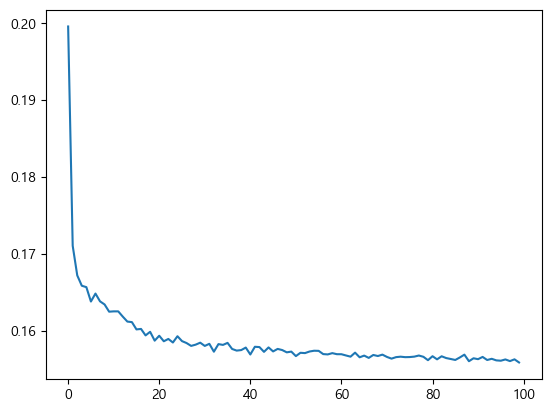

In [22]:
plt.plot(lstm_history.history.history['loss'])

In [23]:
lstm_pred = model.lstm_predict()

32/32 [==============================] - 0s 1ms/step


In [24]:
real_lstm_pred = scaler.inverse_transform(lstm_pred)

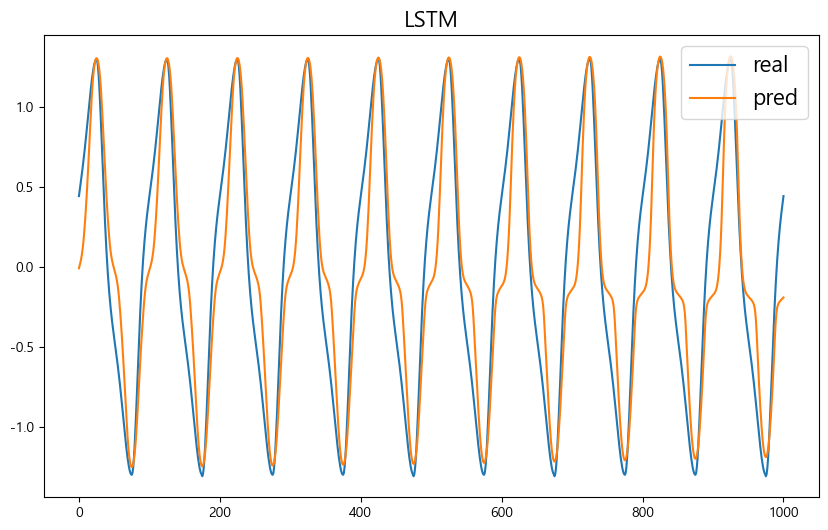

In [25]:
plt.figure(figsize = (10,6))
plt.title('LSTM', fontsize = 16)
plt.plot(test_y, label = 'real')
plt.plot(real_lstm_pred.reshape(1,-1)[0], label = 'pred')
plt.legend(fontsize = 16)
plt.show()

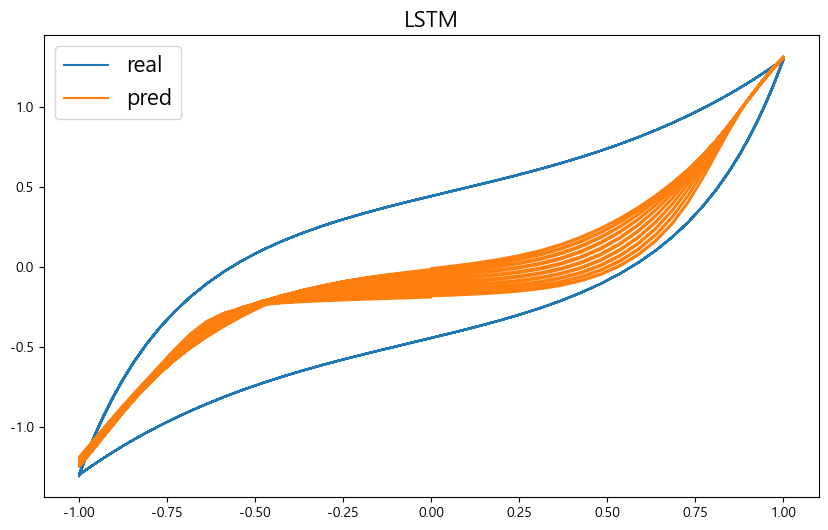

In [26]:
plt.figure(figsize = (10,6))
plt.title('LSTM', fontsize = 16)
plt.plot(test_x[:,0], test_y, label='real')
plt.plot(test_x[:,0], real_lstm_pred, label='pred')
plt.legend(fontsize = 16)
plt.show()

In [4]:
import scipy

In [5]:
class PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer_z = tf.keras.layers.Dense(units=1)  # To predict z
        self.output_layer_f = tf.keras.layers.Dense(units=output_dim)  # To predict F(t)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        z = self.output_layer_z(x)
        f = self.output_layer_f(x)
        return z, f  # Return both z and F(t)

def compute_boucwen_dynamics(u, z, A, B, G, n):
    # No need to compute gradients here as TensorFlow can automatically compute them during training
    # z = tf.clip_by_value(z, -1e2, 1e2)
    Z_dot = A*u - B*(tf.abs(u)*tf.abs(z)**(n-1)*z) - G*u*tf.abs(z)**n
    return Z_dot

def boucwen_loss(y_true, y_pred_f, u, z_pred, A, B, G, n):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    Z_dot_pred = compute_boucwen_dynamics(u, z_pred, A, B, G, n)
    
    # Compute physics_loss and data_loss
    physics_loss = tf.reduce_mean(tf.square(Z_dot_pred - z_pred))  # Z_dot_pred should be equal to z_pred according to the Bouc-Wen model
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred_f))  # Predicted F(t) should be close to the true values

    return 0.5 * physics_loss + 0.5 * data_loss  

def train_step_boucwen(x_tr, y_tr, A, B, G, n):
    u = x_tr[:, 0]
    u = tf.convert_to_tensor(u)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(u)
        z_pred, y_pred_f = model_pinn_boucwen(x_tr, training=True)
        loss_value = boucwen_loss(y_tr, y_pred_f, u, z_pred, A, B, G, n)
    gradients = tape.gradient(loss_value, model_pinn_boucwen.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_pinn_boucwen.trainable_variables))
    return loss_value


In [6]:
import inspect

In [7]:
import tensorflow as tf

class Modified_PINN_BoucWen(tf.keras.Model):
    def __init__(self, output_dim, dt=0.01):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer_z = tf.keras.layers.Dense(units=1)  # To predict z
        self.output_layer_f = tf.keras.layers.Dense(units=output_dim)  # To predict F(t)
        self.dt = dt

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        z = self.output_layer_z(x)
        f = self.output_layer_f(x)
        return z, f  # Return both z and F(t)
    
    def compute_boucwen_dynamics(self, u, z, A, B, G, n):
        Z_dot = A*u - B*(tf.abs(u)*tf.abs(z)**(n-1)*z) - G*u*tf.abs(z)**n
        return Z_dot

    def integrate_z(self, Z_dot_pred):
        z_pred = [tf.zeros_like(Z_dot_pred[0])]  # Start with zero initial condition matching the shape of Z_dot_pred elements
        for i in range(1, len(Z_dot_pred)):
            z_next = z_pred[-1] + 0.5 * self.dt * (Z_dot_pred[i-1] + Z_dot_pred[i])
            z_pred.append(z_next)
        return tf.stack(z_pred)

    def boucwen_loss(self, y_true, y_pred_f, u, z_pred, A, B, G, n):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_true = tf.expand_dims(y_true, axis=-1)
        Z_dot_pred = self.compute_boucwen_dynamics(u, z_pred, A, B, G, n)
        z_integrated = self.integrate_z(Z_dot_pred)
        
        physics_loss = tf.reduce_mean(tf.square(z_integrated - y_true))
        data_loss = tf.reduce_mean(tf.square(y_true - y_pred_f))
        return 0.5 * physics_loss + 0.5 * data_loss  

    def train_step_boucwen(self, x_tr, y_tr, A, B, G, n):
        u = x_tr[:, 0]
        u = tf.convert_to_tensor(u)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(u)
            z_pred, y_pred_f = self(x_tr, training=True)
            loss_value = self.boucwen_loss(y_tr, y_pred_f, u, z_pred, A, B, G, n)
        gradients = tape.gradient(loss_value, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss_value


In [8]:
model_pinn_boucwen = Modified_PINN_BoucWen(output_dim=1, dt=0.01)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [18]:
x_tr = tf.convert_to_tensor(train_x)
y_tr = tf.convert_to_tensor(train_y)
x_te = tf.convert_to_tensor(test_x)
y_te = tf.convert_to_tensor(test_y)

In [19]:
x_tr = tf.cast(x_tr, dtype=tf.float32)
y_tr = tf.cast(y_tr, dtype=tf.float32)
x_te = tf.cast(x_te, dtype=tf.float32)
y_te = tf.cast(y_te, dtype=tf.float32)

In [20]:
epochs = 10

In [21]:
A = 3  
B = 5  
G = 1  
n = 2000

A = 0.1
B = 0.1
G = 0.1
n = 5

In [24]:
from tqdm import tqdm

In [32]:
tf.data.Dataset.from_tensor_slices((x_tr, y_tr)).batch(64).shuffle(buffer_size=10000)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

batch_size = 32

# 데이터를 배치로 나누기
dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr)).batch(batch_size).shuffle(buffer_size=10000)

loss_record = []
for epoch in tqdm(range(epochs)):
    epoch_loss = []  # 각 에포크의 배치별 손실을 저장하기 위한 리스트
    for batch_x, batch_y in dataset:
        loss = model_pinn_boucwen.train_step_boucwen(batch_x, batch_y, A, B, G, n)
        epoch_loss.append(loss.numpy())
    
    # 각 에포크의 평균 손실 계산
    avg_loss = np.mean(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")
    loss_record.append(avg_loss)

In [ ]:
loss_record = []
for epoch in tqdm(range(epochs)):
    loss = model_pinn_boucwen.train_step_boucwen(x_tr, y_tr, A, B, G, n)
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")
    loss_record.append(loss.numpy())

In [ ]:
z_pred, y_pred_f = model_pinn_boucwen(x_te)

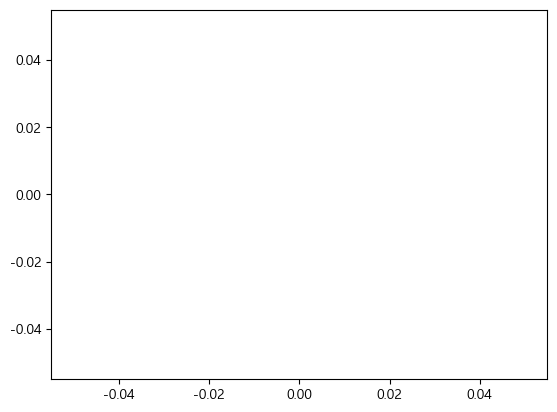

In [ ]:
plt.plot(z_pred)

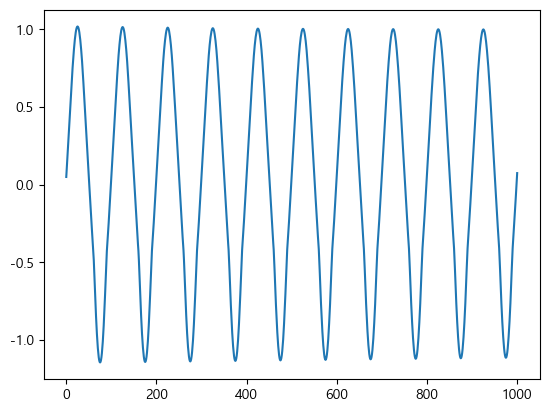

In [ ]:
plt.plot(y_pred_f)

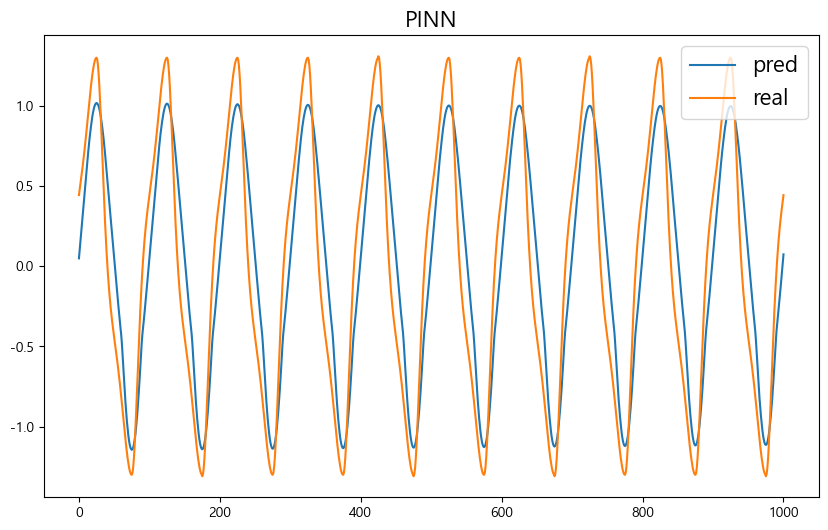

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(y_pred_f, label = 'pred')
plt.plot(y_te, label = 'real')
plt.title('PINN', fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

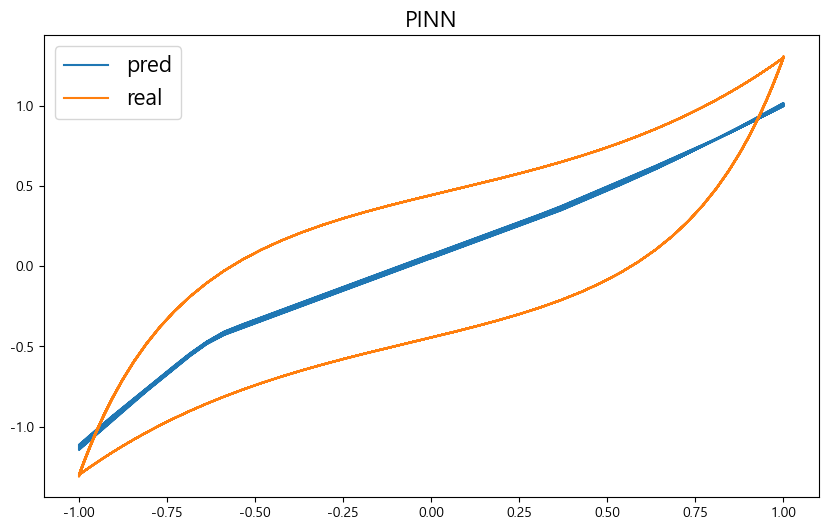

In [44]:
plt.figure(figsize = (10, 6))
plt.plot(test_x[:,0], y_pred_f, label = 'pred')
plt.plot(test_x[:,0], y_te, label = 'real')
plt.legend(fontsize = 16)
plt.title('PINN', fontsize= 16)
plt.show()